In [1]:
import pandas as pd

In [ ]:
# Import data
re_df = pd.read_csv("../data/real_estate.csv")
refnis_df = pd.read_excel("../data/postal_refnis_conv.xlsx")
income_df = pd.read_excel("../data/taxable_income.xlsx")

### Sources:
- Postal code and refnis conversion: https://statbel.fgov.be/nl/over-statbel/methodologie/classificaties/geografie
- Taxable income per region: https://statbel.fgov.be/en/themes/households/taxable-income#figures

In [3]:
re_df.head()

,zip_code,commune,province,type_of_property,subtype_of_property,price,building_condition,facade_number,living_area,equipped_kitchen,...,furnished,open_fire,terrace,garden,plot_surface,terrace_encoded,equipped_kitchen_encoded,building_condition_encoded,subtype_of_property_encoded,commune_encoded
0,2600,Berchem,Antwerpen,0,apartment,149000.0,good,2.0,48,installed,...,0,0,9,0,0,1,2,3,0,34.0
1,2100,Deurne,Antwerpen,0,apartment,248000.0,good,2.0,91,installed,...,0,0,2,0,0,1,2,3,0,75.0
2,2660,Hoboken,Antwerpen,0,apartment,229000.0,as new,2.0,100,not installed,...,0,0,26,0,0,1,0,5,0,141.0
3,1180,Uccle,Bruxelles,0,apartment,470000.0,good,2.0,179,hyper equipped,...,0,0,10,0,0,1,3,3,0,514.0
4,2018,Antwerpen,Antwerpen,0,apartment,480000.0,just renovated,2.0,116,installed,...,0,0,7,0,0,1,2,4,0,12.0


In [4]:
income_df.head()

,Administrative Unit,NIS code,Total net taxable income,Average values,Prosperity index,State tax,Municipal and agglomeration tax,Total tax
0,Province of Antwerp,10000,43463433801,39117,104,9722252776,693745919,10415998694
1,Province of East Flanders,40000,36891868109,39945,109,8496779008,604765506,9101544514
2,Province of Flemish Brabant,20001,29808966587,44465,115,7399882917,525793584,7925676501
3,Province of West Flanders,30000,27811507618,37809,105,5880415006,396628007,6277043013
4,Province of Hainaut,50000,25846612361,32560,87,4900705546,415015633,5315721178


In [5]:
refnis_df.head()

,Postal code,Refnis code,Gemeentenaam,Nom commune
0,1000,21004,Brussel,Bruxelles
1,1020,21004,Brussel,Bruxelles
2,1030,21015,Schaarbeek,Schaerbeek
3,1040,21004,Brussel,Bruxelles
4,1040,21005,Etterbeek,Etterbeek


In [6]:
# Merge columns from refnis_df in re_df based on postal code
re_df = pd.merge(
    re_df,
    refnis_df[["Postal code", "Refnis code"]],
    left_on="zip_code",
    right_on="Postal code",
    how="left",
)
# how='left' ensures that all rows from re_df are kept and the corresponding values from refnis_df is added

# Drop the extra 'Postal code' column
re_df = re_df.drop(columns=["Postal code"])

In [7]:
re_df.columns

Index(['zip_code', 'commune', 'province', 'type_of_property',
       'subtype_of_property', 'price', 'building_condition', 'facade_number',
       'living_area', 'equipped_kitchen', 'bedroom_nr', 'swimming_pool',
       'furnished', 'open_fire', 'terrace', 'garden', 'plot_surface',
       'terrace_encoded', 'equipped_kitchen_encoded',
       'building_condition_encoded', 'subtype_of_property_encoded',
       'commune_encoded', 'Refnis code'],
      dtype='object')

In [8]:
income_df.columns

Index(['Administrative Unit', 'NIS code', 'Total net taxable income',
       'Average values', 'Prosperity index', 'State tax',
       'Municipal and agglomeration tax', 'Total tax'],
      dtype='object')

In [9]:
# Merge columns from income_df in re_df based on refnis code
re_df = pd.merge(
    re_df,
    income_df[
        ["NIS code", "Total net taxable income", "Average values", "Prosperity index"]
    ],
    left_on="Refnis code",
    right_on="NIS code",
    how="left",
)  # keep left

# Rename the imported columns
re_df = re_df.rename(
    columns={
        "Total net taxable income": "com_tot_income",
        "Average values": "com_avg_income",
        "Prosperity index": "com_prosp_index",
    }
)

# Drop 'NIS code'
re_df = re_df.drop(columns=["NIS code"])

In [10]:
re_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17763 entries, 0 to 17762
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   zip_code                     17763 non-null  int64  
 1   commune                      17763 non-null  object 
 2   province                     17763 non-null  object 
 3   type_of_property             17763 non-null  int64  
 4   subtype_of_property          17763 non-null  object 
 5   price                        17763 non-null  float64
 6   building_condition           17763 non-null  object 
 7   facade_number                17763 non-null  float64
 8   living_area                  17763 non-null  int64  
 9   equipped_kitchen             17763 non-null  object 
 10  bedroom_nr                   17763 non-null  int64  
 11  swimming_pool                17763 non-null  int64  
 12  furnished                    17763 non-null  int64  
 13  open_fire       

### Warning: 'Garden' has only 0 values!

* Removed from features as it improved performance

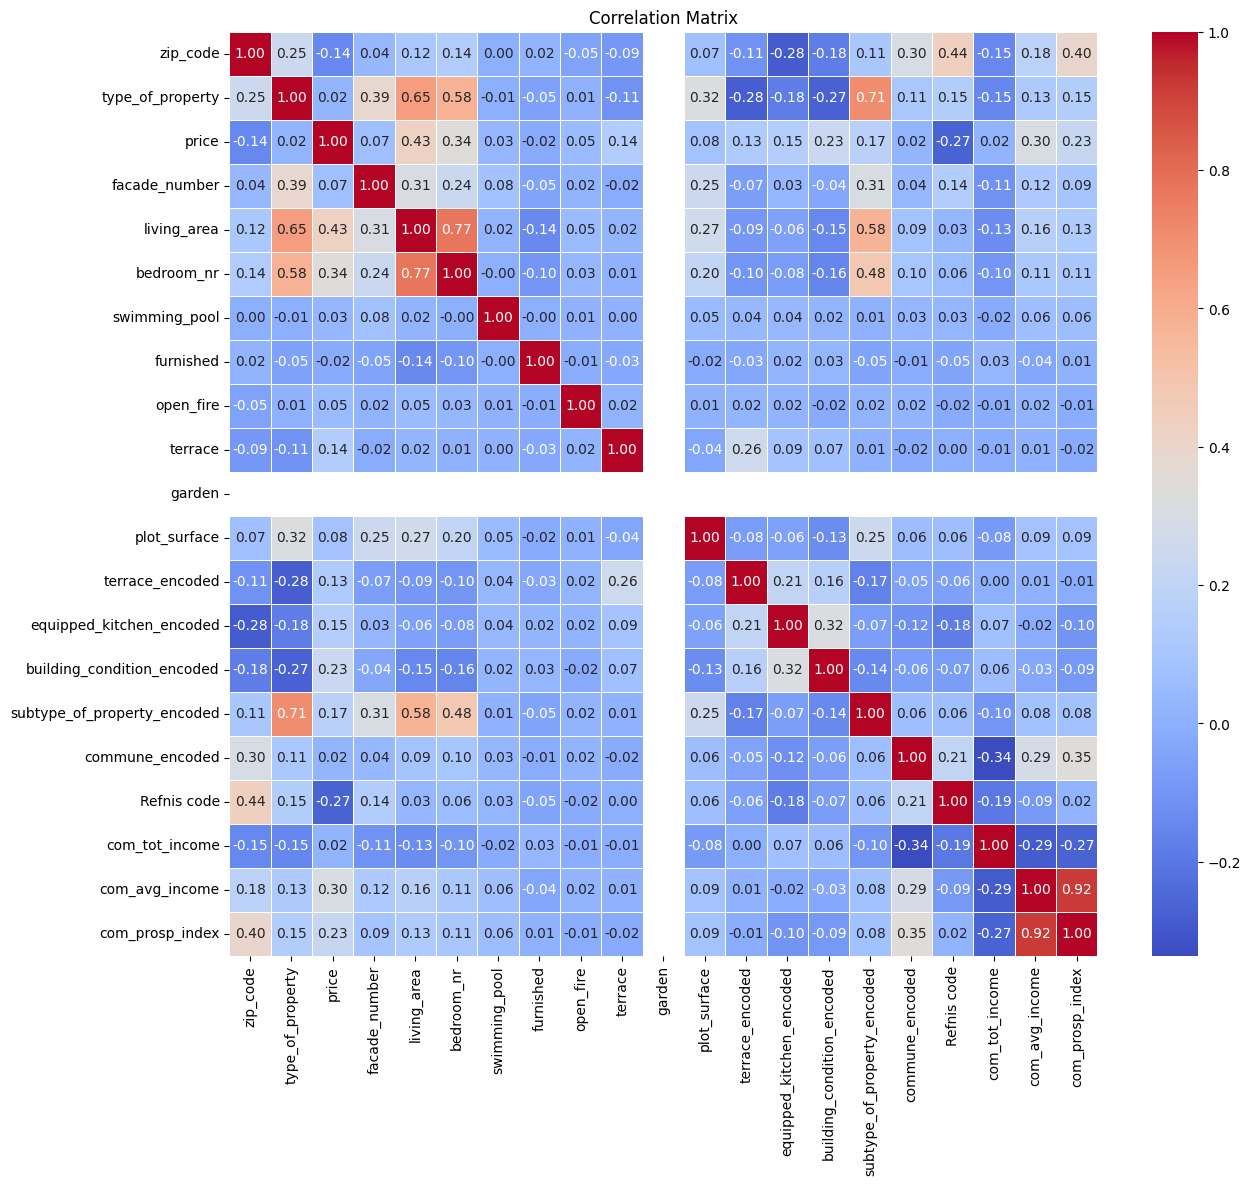

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter numer
numerical_cols = re_df.select_dtypes(
    include=["number"]
).columns  # Select only numerical columns
correlation_matrix = re_df[numerical_cols].corr()  # Compute the correlation matrix

# Plot the correlation matrix using seaborn
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Interpreting Results

**Options:**

* SHAP:
  * Computationally too costly to employ efficiently, even with reduction of background data size

* Distance-based analysis:  
  * features that contribute more to the distance calculations may be deemed more important.

* Permutation Importance:
  * measure the model’s performance degradation after shuffling a feature’s values.



In [23]:
# Clustering based on commune and taxable income

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Assuming 're_df' contains the original data and already has 'commune_encoded' and 'com_avg_income'

# Normalize the features (only 'com_avg_income' and 'commune_encoded')
scaler = StandardScaler()
scaled_features = scaler.fit_transform(re_df[["com_avg_income", "commune_encoded"]])

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.2, min_samples=4)
re_df["commune_income_cluster"] = dbscan.fit_predict(scaled_features)

# Sort communes by income in descending order
# re_df_sorted = re_df.sort_values(by='com_avg_income', ascending=False)

# Get the unique cluster labels and reverse them
unique_labels = sorted(re_df["commune_income_cluster"].unique(), reverse=True)
label_mapping = {
    old_label: new_label
    for old_label, new_label in zip(
        sorted(re_df["commune_income_cluster"].unique()), unique_labels
    )
}

# Map the reversed labels back to the original DataFrame
re_df["commune_income_cluster_reversed"] = re_df["commune_income_cluster"].map(
    label_mapping
)

# Inspect the result
re_df[
    [
        "commune",
        "com_avg_income",
        "commune_income_cluster",
        "commune_income_cluster_reversed",
    ]
].head()

# Drop 'commune_income_cluster'
re_df = re_df.drop(columns=["commune_income_cluster"])

# Rename 'commune_income_cluster_reversed'
re_df = re_df.rename(
    columns={"commune_income_cluster_reversed": "commune_income_cluster"}
)

# Inspect the result
re_df[["commune", "com_avg_income", "commune_income_cluster"]].head()

,commune,com_avg_income,commune_income_cluster
0,Berchem,33144,24
1,Deurne,33144,24
2,Hoboken,33144,24
3,Uccle,43622,24
4,Antwerpen,33144,24


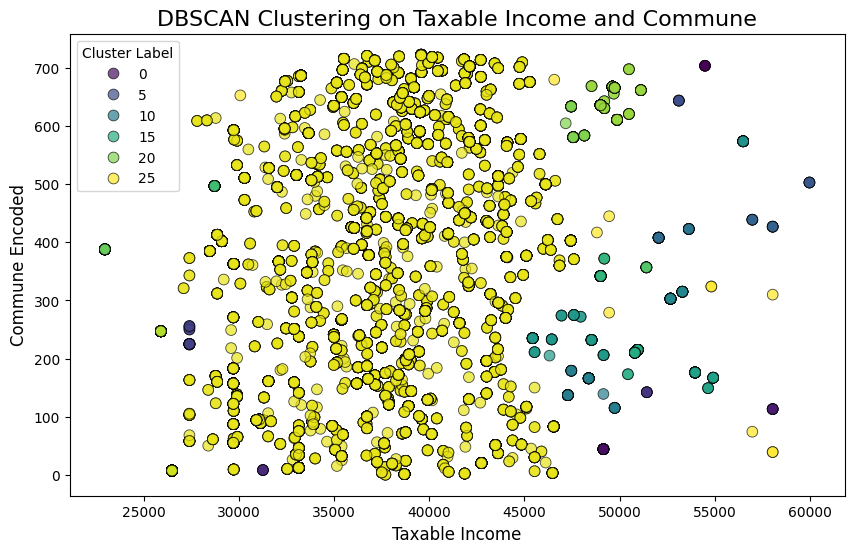

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting DBSCAN clustering result
plt.figure(figsize=(10, 6))

# Create a scatter plot where the x-axis is taxable_income, and y-axis is commune_encoded
# Points are colored according to their DBSCAN cluster label
sns.scatterplot(
    x=re_df["com_avg_income"],
    y=re_df["commune_encoded"],
    hue=re_df["commune_income_cluster"],
    palette="viridis",  # You can change this to any color palette you like
    marker="o",
    s=60,  # Size of the points
    edgecolor="black",  # Edge color for points
    alpha=0.7,
)  # Transparency of the points

# Add labels and title
plt.title("DBSCAN Clustering on Taxable Income and Commune", fontsize=16)
plt.xlabel("Taxable Income", fontsize=12)
plt.ylabel("Commune Encoded", fontsize=12)

# Show plot
plt.legend(title="Cluster Label")
plt.show()

In [22]:
columns = ["1", "2", "3"]
new_column = "_".join(columns)
new_column

'1_2_3'

In [37]:
df_selected = pd.read_csv("./data/real_estate_selected.csv")

In [38]:
df_selected.drop(columns="Unnamed: 0")
df_selected.columns

Index(['Unnamed: 0', 'price', 'commune_encoded', 'zip_code', 'living_area',
       'building_condition_encoded', 'terrace_encoded',
       'equipped_kitchen_encoded', 'subtype_of_property_encoded',
       'com_avg_income', 'commune_income_cluster'],
      dtype='object')

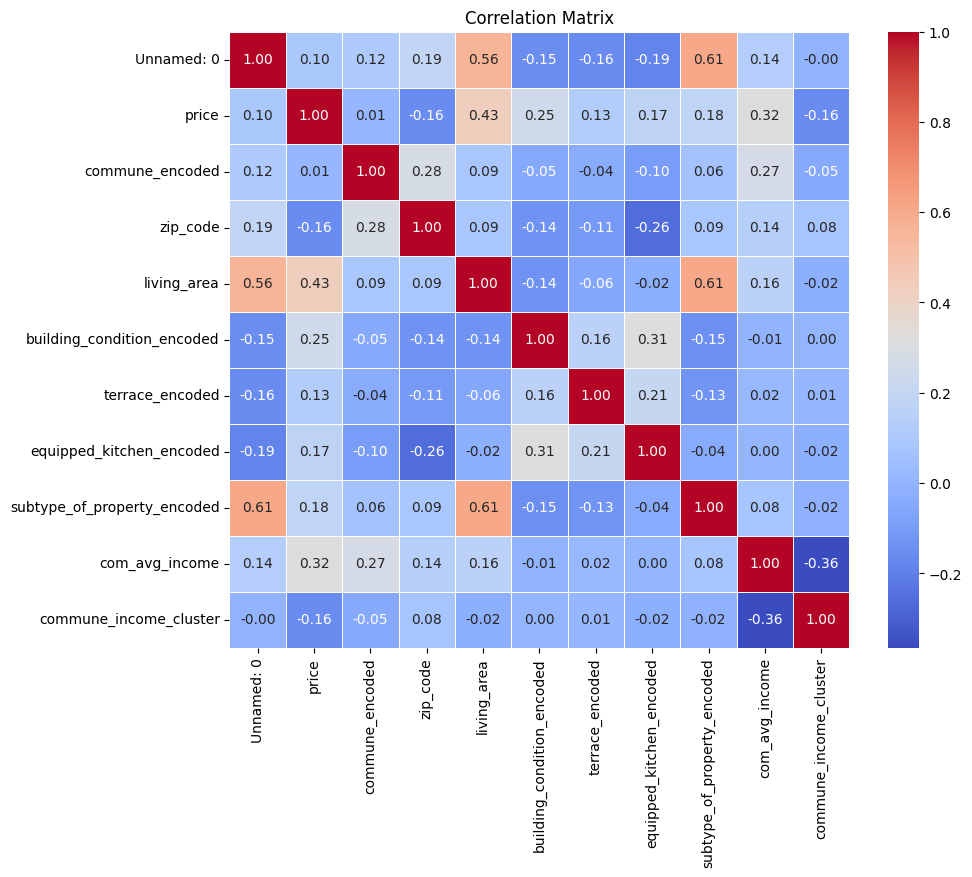

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter numer
numerical_cols = df_selected.select_dtypes(
    include=["number"]
).columns  # Select only numerical columns
correlation_matrix = df_selected[
    numerical_cols
].corr()  # Compute the correlation matrix

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Script to Import Latitude Longitude

In [54]:
df = pd.read_csv("./data/real_estate.csv")

In [ ]:
"""# Correct value for commune
from data_utils import DataUtils
df = DataUtils.correct_value(df, column='commune', old_value='Petit-Rulx-lez-Nivelles', new_value='Petit-Rœulx-lez-Nivelles')

df.to_csv("./data/real_estate_corrected.csv")"""

In [ ]:
from geopy.geocoders import Nominatim
import pandas as pd

# Get list of unique communes
communes = df["commune"].unique()

# Initialize geocoder
geolocator = Nominatim(user_agent="geoapi")


# Get latitude and longitude
def get_lat_lon(commune):
    location = geolocator.geocode(commune + ", Belgium")
    if location:
        return location.latitude, location.longitude
    else:
        return None, None


# Create a DataFrame with unique communes and their lat/lon
commune_lat_lon = pd.DataFrame(communes, columns=["commune"])
commune_lat_lon[["latitude", "longitude"]] = (
    commune_lat_lon["commune"].apply(get_lat_lon).apply(pd.Series)
)

# Map the latitude and longitude to the original df_encoded
raw_df = df.merge(commune_lat_lon, on="commune", how="left")

In [ ]:
df.isna().sum()

zip_code                  0
commune                   0
province                  0
type_of_property          0
subtype_of_property       0
price                    36
building_condition     6690
facade_number          9362
living_area               0
equipped_kitchen          0
bedroom_nr                0
swimming_pool             0
furnished                 0
open_fire                 0
terrace                   0
garden                    0
plot_surface              0
latitude                  0
longitude                 0
dtype: int64

### 10 Largest Cities in Belgium + Latitude/Longitude

* https://www.geonames.org/BE/largest-cities-in-belgium.html
* https://www.statista.com/statistics/525853/the-10-largest-cities-and-municipalities-in-belgium/

* Brussels, Antwerp, Ghent, Charleroi, Liège, Anderlecht, Schaarbeek, Bruges, Namur, Leuven, Molenbeek-Saint-Jean, Mons

In [ ]:
# Get coordinates of 10 largest cities in belgium

from geopy.geocoders import Nominatim
import time


def get_commune_coordinates(commune_list):
    geolocator = Nominatim(user_agent="commune_coordinates_extractor")
    coordinates_dict = {}

    for commune in commune_list:
        try:
            # Fetch location
            location = geolocator.geocode(commune + ", Belgium")

            # If a valid location is found, add it to the dictionary
            if location:
                coordinates_dict[commune] = (location.latitude, location.longitude)
            else:
                coordinates_dict[commune] = None  # In case the commune isn't found

            # Pause to avoid overwhelming the geocoding service with requests
            time.sleep(1)
        except Exception as e:
            print(f"Error fetching coordinates for {commune}: {e}")
            coordinates_dict[commune] = None

    return coordinates_dict

In [52]:
# Example usage:
cities_list = [
    "Brussels",
    "Antwerp",
    "Ghent",
    "Charleroi",
    "Liège",
    "Anderlecht",
    "Schaarbeek",
    "Bruges",
    "Namur",
    "Leuven",
    "Molenbeek-Saint-Jean",
    "Mons",
]
cities_dict = get_commune_coordinates(cities_list)
cities_dict

{'Brussels': (50.8465573, 4.351697),
 'Antwerp': (51.2211097, 4.3997081),
 'Ghent': (51.0538286, 3.7250121),
 'Charleroi': (50.4116233, 4.444528),
 'Liège': (50.6450944, 5.5736112),
 'Anderlecht': (50.8390983, 4.3296526),
 'Schaarbeek': (50.8676041, 4.3737121),
 'Bruges': (51.2085526, 3.226772),
 'Namur': (50.4665284, 4.8661892),
 'Leuven': (50.879202, 4.7011675),
 'Molenbeek-Saint-Jean': (50.8545959, 4.338636),
 'Mons': (50.4549568, 3.951958)}

In [ ]:
# Calculate distance to nearest large city in Belgium

import pandas as pd
import geopy.distance


# Function to calculate the distance to the nearest city
def calculate_nearest_city(lat, lon, cities):
    distances = {}
    for city, coords in cities.items():
        city_lat, city_lon = coords
        distance = geopy.distance.distance((lat, lon), (city_lat, city_lon)).km
        distances[city] = distance
    # Return the minimum distance
    return min(distances.values())

In [ ]:
# Apply the function to each commune in your dataset
df["nearest_city_distance"] = df.apply(
    lambda row: calculate_nearest_city(row["latitude"], row["longitude"], cities),
    axis=1,
)

In [49]:
# Calculate Haversine distance between two sets of latitude/longitude points

from math import radians, sin, cos, sqrt, atan2


def haversine(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    R = 6371  # Radius of Earth in km
    return R * c

In [50]:
# Calculate the minimum distance to the nearest city for each commune


def calculate_nearest_city_distance(row, cities):
    lat_commune = row["latitude"]
    lon_commune = row["longitude"]

    min_distance = float("inf")  # Start with an infinitely large distance

    for city, (lat_city, lon_city) in cities.items():
        distance = haversine(lat_commune, lon_commune, lat_city, lon_city)
        if distance < min_distance:
            min_distance = distance

    return min_distance

In [ ]:
# Apply function to dataframe
df["distance_to_nearest_city"] = df.apply(
    calculate_nearest_city_distance, axis=1, cities=cities_dict
)

In [68]:
# Load df with min_distance
import pandas as pd

df = pd.read_csv("./data/real_estate_encoded.csv")

In [69]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'zip_code', 'commune', 'province',
       'type_of_property', 'subtype_of_property', 'price',
       'building_condition', 'facade_number', 'living_area',
       'equipped_kitchen', 'bedroom_nr', 'swimming_pool', 'furnished',
       'open_fire', 'terrace', 'garden', 'plot_surface', 'latitude',
       'longitude', 'terrace_encoded', 'equipped_kitchen_encoded',
       'building_condition_encoded', 'subtype_of_property_encoded',
       'commune_encoded', 'refnis_code', 'com_tot_income', 'com_avg_income',
       'com_prosp_index', 'commune_income_cluster', 'min_distance'],
      dtype='object')

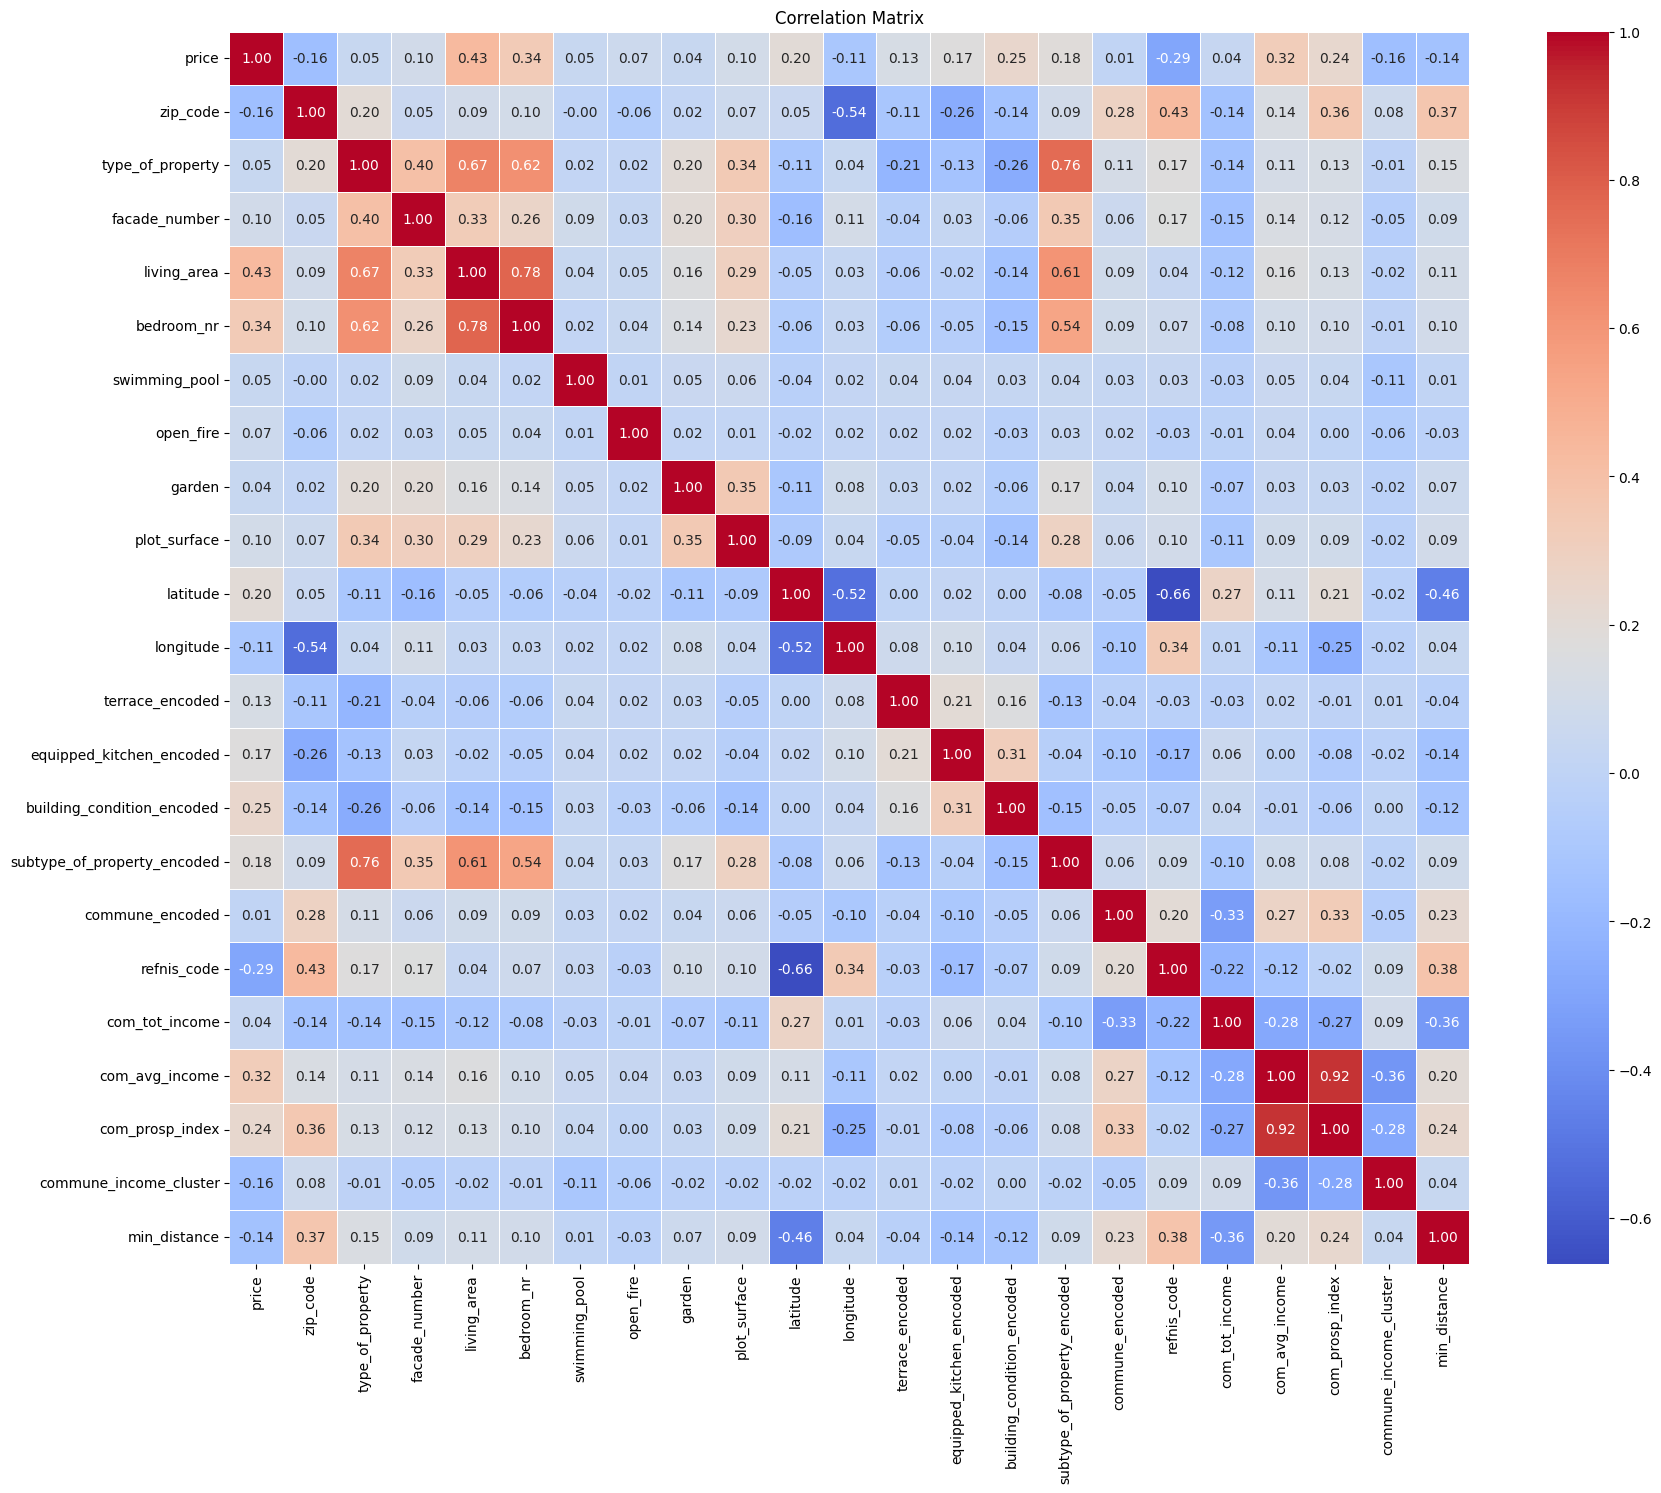

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter number
selected_columns = [
    "price",
    "zip_code",
    "type_of_property",
    "facade_number",
    "living_area",
    "bedroom_nr",
    "swimming_pool",
    "open_fire",
    "garden",
    "plot_surface",
    "latitude",
    "longitude",
    "terrace_encoded",
    "equipped_kitchen_encoded",
    "building_condition_encoded",
    "subtype_of_property_encoded",
    "commune_encoded",
    "refnis_code",
    "com_tot_income",
    "com_avg_income",
    "com_prosp_index",
    "commune_income_cluster",
    "min_distance",
]
correlation_matrix = df[selected_columns].corr()  # Compute the correlation matrix

# Plot the correlation matrix using seaborn
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

**Sorted correlations with price:**

* Living Area
* Average taxable income per commune
* Building Condition
* Latitude
* Subtype
* Equipped Kitchen
* Zip code/ commune income cluster
* Min Distance
* Terrace
* Longitude
* Commune encoded

### Principal Component Analysis

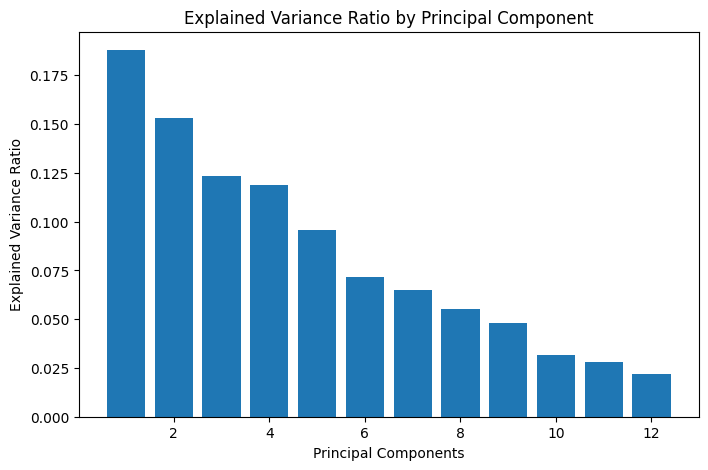

In [63]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from feature_utils import FeatureUtils

# After your feature engineering steps, select numeric features for PCA
features_for_pca = [
    "commune_encoded",
    "zip_code",
    "min_distance",
    "latitude",
    "longitude",
    "com_avg_income",
    "commune_income_cluster",
    "living_area",
    "subtype_of_property_encoded",
    "building_condition_encoded",
    "equipped_kitchen_encoded",
    "terrace_encoded",
]

# Extract feature values
X = FeatureUtils.select_features(df, features=features_for_pca).values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=12)  # You can adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

# Plot the explained variance ratio to see how much variance each component captures
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio by Principal Component")
plt.show()

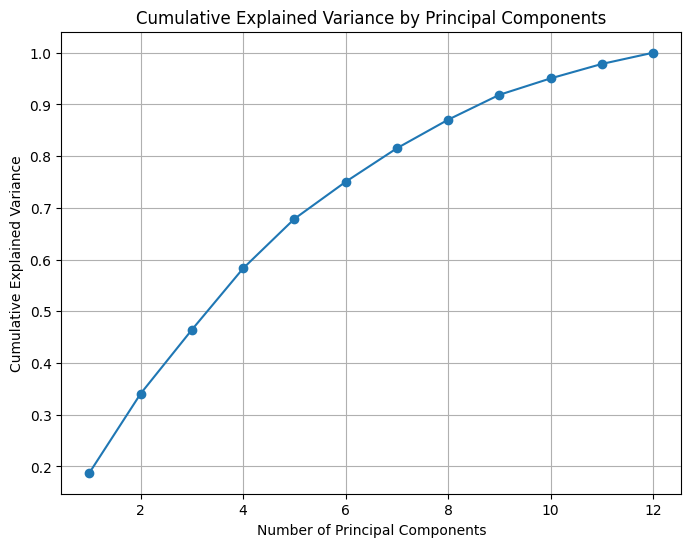

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'pca' is the fitted PCA model
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker="o")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by Principal Components")
plt.grid(True)
plt.show()